# IMPORTS AND DATA

In [79]:
from fireTS.models import NARX, DirectAutoRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
import seaborn as sns
import plotly.express as px

In [83]:
import pandas as pd
import glob
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow 
import autokeras as ak
import scipy.io
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN

In [327]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Results2/*.txt"))))
X=df.drop(columns=['SOC_tot'])
y=df.SOC_tot
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

In [174]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt"))))
X_train=df.drop(columns=['SOC_tot'])
y_train = df.SOC_tot

df_test = pd.read_csv('../raw_data/long_discharge_cycles/complete_chargeonly_results1.txt')
X_test=df_test.drop(columns=['SOC_tot'])
y_test = df_test.SOC_tot

# NARX

In [175]:
mdl1 = NARX(
    LinearSVR(),
    auto_order=6,
    exog_order=[1,1,1,1],
    )

mdl1.fit(X_train, y_train)
ypred1 = mdl1.predict(X_test, y_test, step=3)

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [52]:
len1 = len(ypred1[11:])


X_len1 = np.linspace(0,len1,len1)
print(mean_absolute_error(ypred1[11:],y_test[11:]))
print(mean_squared_error(ypred1[11:],y_test[11:], squared=False))

0.05571251154988908
0.06693178556520302


In [235]:
ypred_test = mdl1.forecast(X_test, y_test, step=10)

In [ ]:
mdl2 = DirectAutoRegressor(
    LinearRegression(),
    auto_order=6,
    exog_order=[1, 1,1,1],
    pred_step=3)

mdl2.fit(X_train, y_train)
ypred2 = mdl2.predict(X_test, y_test)

In [ ]:
mdl3 = NARX(
    SVR(),
    auto_order=1,
    exog_order=[1, 1,1,1]
    )

mdl3.fit(X_train, y_train)
ypred3 = mdl3.predict(X_test, y_test)

In [ ]:
print(mdl1.score(X_test,y_test, method='mse'))
print(mdl2.score(X_test,y_test, method='mse'))
#print(mdl3.score(X_test,y_test, method='mse'))

# PLOTS

0.025703326248429997
0.031061941973712454


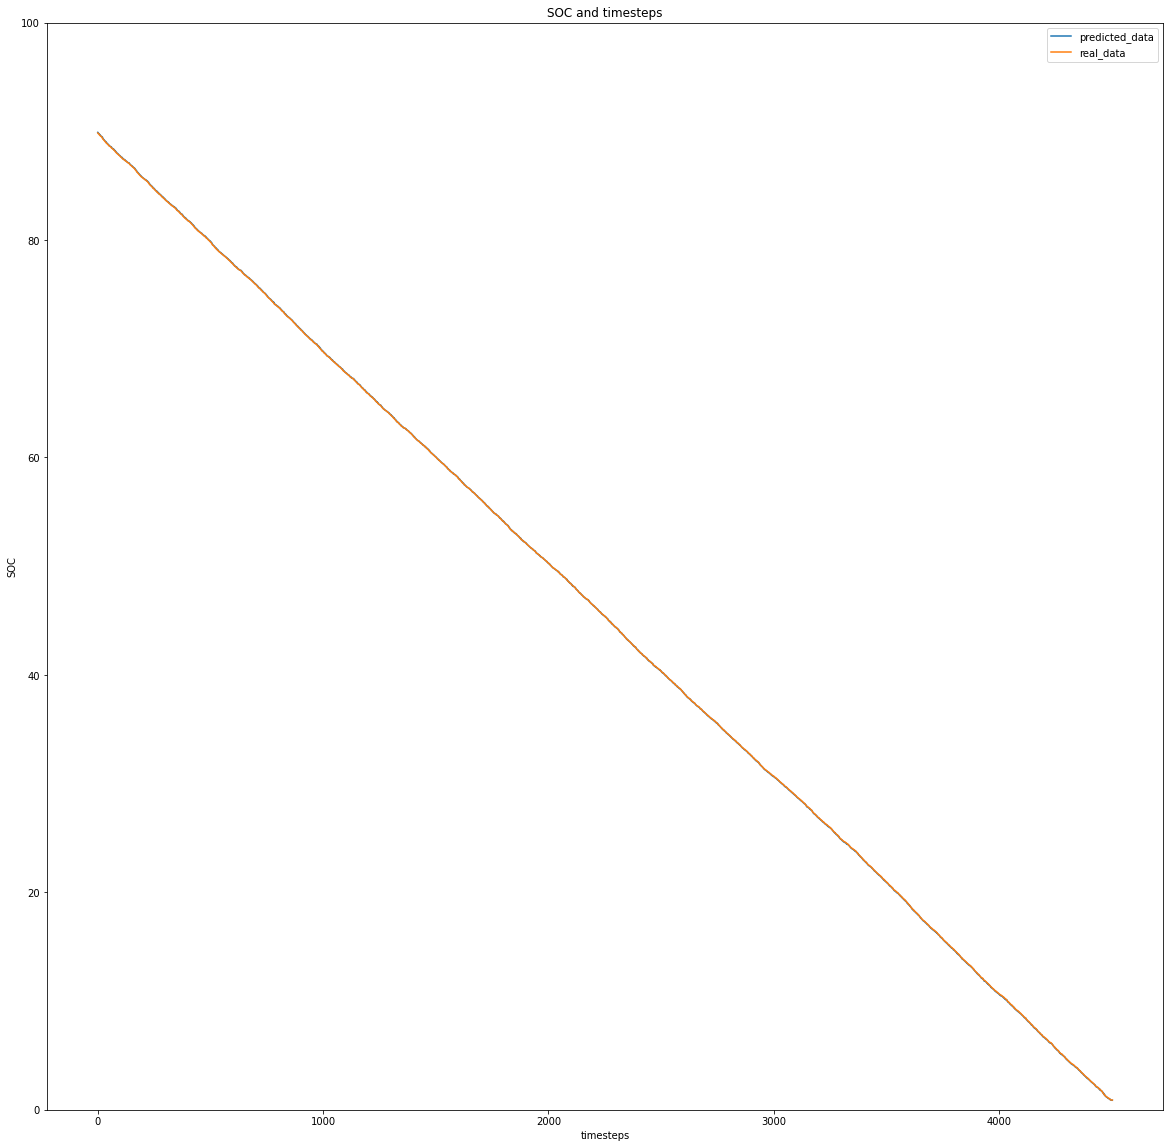

In [176]:
len1 = len(ypred1[11:])


X_len1 = np.linspace(0,0.5*len1,len1)

print(mean_absolute_error(ypred1[11:],y_test[11:]))
print(mean_squared_error(ypred1[11:],y_test[11:], squared=False))

plt.figure(figsize=(20,20))
plt.plot(X_len1,ypred1[11:], label='predicted_data')
plt.plot(X_len1,y_test[11:], label='real_data')
plt.title('SOC and timesteps')
plt.xlabel('timesteps')
plt.ylabel('SOC')
plt.legend()
plt.ylim(0,100)
plt.show()

In [77]:
ypred1

array([        nan,         nan,         nan, ..., 74.49479667,
       74.49692266, 74.49136559])

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


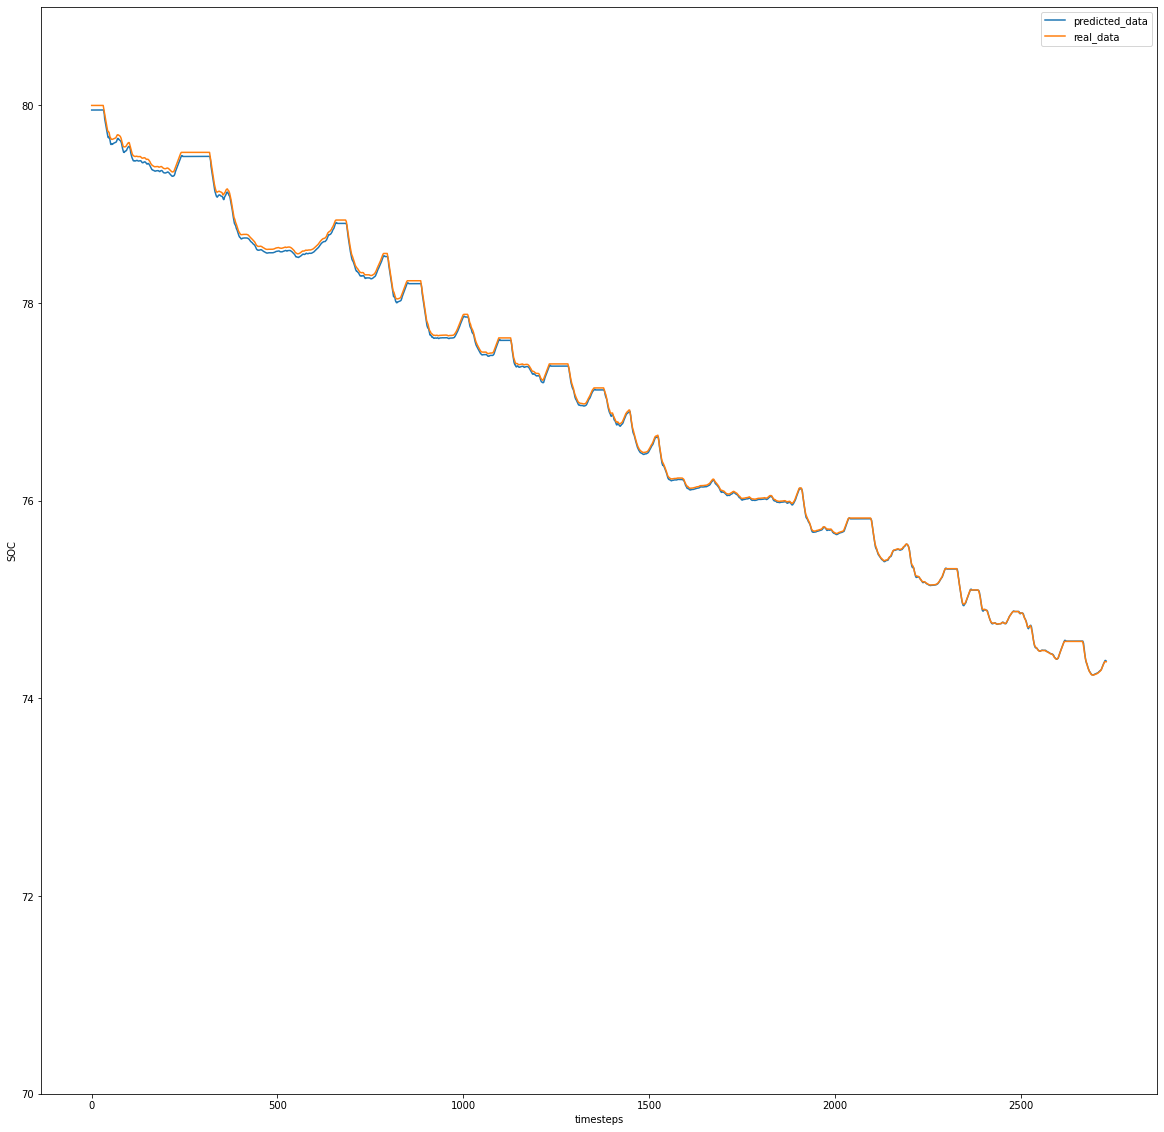

In [22]:
plt.figure(figsize=(20,20))

sns.lineplot(X_len1,ypred1[11:], label='predicted_data')
sns.lineplot(X_len1,y_test[11:], label='real_data')
plt.xlabel('timesteps')
plt.ylabel('SOC')
plt.legend()
plt.ylim(70,81)
plt.show()

In [29]:
#sns.lineplot(X_len1,ypred1[11:], label='predicted_data')
fig=px.line(x=X_len1,y=y_test[11:])
fig.show()

In [43]:
df_plot = pd.DataFrame({
    'x_axis':X_len1,
    'y_axis':y_test[11:],
    'y_axis2':ypred1[11:]
})


In [45]:
fig1 = px.line(df_plot, x='x_axis',y='y_axis')
fig1.update_traces(line=dict(color= 'rgba(50,50,50,0.2)'))
fig2 = px.scatter(df_plot,x='x_axis',y='y_axis2')

fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

<IPython.core.display.Javascript object>

In [ ]:
len1 = len(ypred2[10:])


X_len1 = np.linspace(0,len1,len1)
print(mean_absolute_error(ypred2[10:],y_test[10:]))
print(mean_squared_error(ypred2[10:],y_test[10:], squared=False))

plt.figure(figsize=(10,10))
plt.plot(X_len1,ypred2[10:], label='predicted_data')
plt.plot(X_len1,y_test[10:], label='real_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.ylim(70,82)
plt.show()

In [ ]:
len1 = len(ypred3[10:])


X_len1 = np.linspace(0,len1,len1)
print(mean_absolute_error(ypred3[10:],y_test[10:]))
print(mean_squared_error(ypred3[10:],y_test[10:], squared=False))

plt.figure(figsize=(20,20))
plt.plot(X_len1,ypred3[10:], label='predicted_data')
plt.plot(X_len1,y_test[10:], label='real_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.ylim(77,82)
plt.show()

# CNN-LSTM

In [365]:
def cnn_lstm():

    # train, test = train_test_split(df, shuffle=True, test_size=0.2)
    epochs=10
    df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/Results2/*.txt")))) # read data 
    y_col='SOC_tot' # define y variable, i.e., what we want to predict

    test_size = int(len(df) * 0.1) # here I ask that the test data will be 10% (0.1) of the entire data
    
    train = df.iloc[:-test_size,:].copy() 
    # Try using .loc[row_index,col_indexer] = value instead
    test = df.iloc[-test_size:,:].copy()
    y_col='SOC_tot' # define y variable, i.e., what we want to predict

    X_train = train.drop(y_col, axis=1).copy()
    y_train = train[[y_col]].copy() # the double brackets here are to keep the y in dataframe format, otherwise it will be pandas Series
    
    Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
    Xscaler.fit(X_train)
    scaled_X_train = Xscaler.transform(X_train)
    
    Yscaler = MinMaxScaler(feature_range=(0, 1))
    Yscaler.fit(y_train)
    scaled_y_train = Yscaler.transform(y_train)
    scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimension from y so the shape changes from (n,1) to (n,)

    scaled_y_train = np.insert(scaled_y_train, 0, 0)
    scaled_y_train = np.delete(scaled_y_train, -1)

    n_input = 10 # how many samples/rows/timesteps to look in the past in order to forecast the next sample
    n_features = X_train.shape[1] # how many predictors/Xs/features we have to predict y
    b_size = 25 # Number of timeseries samples in each batch
    X_train, y_train = np.array(X_train), np.array(y_train)

    generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
    X_test = test.drop(y_col, axis=1).copy()
    y_test = test[[y_col]].copy()

    scaled_X_test = Xscaler.transform(X_test)
    Yscaler.fit(y_test)
    scaled_y_test = Yscaler.transform(y_test)
    scaled_y_test = scaled_y_test.reshape(-1)
    test_generator = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=n_input, batch_size=b_size)

    # building the model

    model = Sequential()

    # convolutional layers

    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(n_input, n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # model.add(Flatten())

    # lstm layers

    model.add(LSTM(12, activation='relu', return_sequences=False))

    # dense layers

    model.add(Dense(1))
    tf.keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad")
    tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam")

    model.compile(optimizer='Adam', loss='mae')

    # fitting the model

    model.fit(generator, epochs=epochs, verbose=1, validation_data=test_generator)

    # generating a pandas dataframe of results

    y_pred_scaled = model.predict(test_generator)
    y_pred = Yscaler.inverse_transform(y_pred_scaled)
    results = pd.DataFrame({'y_true': test[y_col].values[n_input:], 'y_pred': y_pred.ravel()})

    return model, results

In [366]:
model,results=cnn_lstm()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/10
3604/3604 [==============================] - 25s 5ms/step - loss: 0.0832 - val_loss: 0.0814
Epoch 2/10
  43/3604 [..............................] - ETA: 27s - loss: 0.0184

KeyboardInterrupt: 

In [50]:
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

4.647042881211473
6.220620515455582


In [370]:
def cnn_lstm():

    # train, test = train_test_split(df, shuffle=True, test_size=0.2)
    epochs=10
    df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/Results2/*.txt")))) # read data 

    df_test = pd.read_csv('../raw_data/CSVs/udds.csv')
    y_col='SOC_tot' # define y variable, i.e., what we want to predict

    train = df.iloc[:,:].copy() 
    test = df_test.iloc[:,:].copy() 

    X_train = train.drop(y_col, axis=1).copy()
    y_train = train[[y_col]].copy() # the double brackets here are to keep the y in dataframe format, otherwise it will be pandas Series
    
    Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
    Xscaler.fit(X_train)
    scaled_X_train = Xscaler.transform(X_train)
    
    Yscaler = MinMaxScaler(feature_range=(0, 1))
    Yscaler.fit(y_train)
    scaled_y_train = Yscaler.transform(y_train)
    scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimension from y so the shape changes from (n,1) to (n,)

    scaled_y_train = np.insert(scaled_y_train, 0, 0)
    scaled_y_train = np.delete(scaled_y_train, -1)

    n_input = 10 # how many samples/rows/timesteps to look in the past in order to forecast the next sample
    n_features = X_train.shape[1] # how many predictors/Xs/features we have to predict y
    b_size = 25 # Number of timeseries samples in each batch
    X_train, y_train = np.array(X_train), np.array(y_train)

    generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
    X_test = test.drop(y_col, axis=1).copy()
    y_test = test[[y_col]].copy()

    scaled_X_test = Xscaler.transform(X_test)
    Yscaler.fit(y_test)
    scaled_y_test = Yscaler.transform(y_test)
    scaled_y_test = scaled_y_test.reshape(-1)
    test_generator = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=n_input, batch_size=b_size)

    # building the model

    model = Sequential()

    # convolutional layers

    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(n_input, n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # model.add(Flatten())

    # lstm layers

    model.add(LSTM(12, activation='relu', return_sequences=False))

    # dense layers

    model.add(Dense(1))
    tf.keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad")
    tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam")

    model.compile(optimizer='Adam', loss='mae')

    # fitting the model

    model.fit(generator, epochs=epochs, verbose=1, validation_data=test_generator)

    # generating a pandas dataframe of results

    y_pred_scaled = model.predict(test_generator)
    y_pred = Yscaler.inverse_transform(y_pred_scaled)
    results = pd.DataFrame({'y_true': test[y_col].values[n_input:], 'y_pred': y_pred.ravel()})

    return model, results

In [371]:
model,results=cnn_lstm()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/10
4004/4004 [==============================] - 17s 3ms/step - loss: 0.0639 - val_loss: 0.4091
Epoch 2/10
4004/4004 [==============================] - 17s 4ms/step - loss: 0.0195 - val_loss: 0.3773
Epoch 3/10
4004/4004 [==============================] - 20s 5ms/step - loss: 0.0166 - val_loss: 0.4123
Epoch 4/10
4004/4004 [==============================] - 18s 4ms/step - loss: 0.0160 - val_loss: 0.4012
Epoch 5/10
4004/4004 [==============================] - 17s 4ms/step - loss: 0.0142 - val_loss: 0.3767
Epoch 6/10
4004/4004 [==============================] - 16s 4ms/step - loss: 0.0130 - val_loss: 0.4014
Epoch 7/10
4004/4004 [==============================] - 19s 5ms/step - loss: 0.0121 - val_loss: 0.4224
Epoch 8/10
4004/4004 [==============================] - 17s 4ms/step - loss: 0.0110 - val_loss: 0.4050
Epoch 9/10
4004/4004 [==============================] - 15s 4ms/step - loss: 0.0105 - val_loss: 0.3893
Epoch 10/10
4004/4004 [==============================] - 13s 3ms/step - l

In [372]:
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

2.3472847041888723
2.8270100247333207


# PYBAMM

In [124]:
import pybamm
import numpy as np
import pandas as pd

pybamm.set_logging_level("NOTICE")

model = pybamm.lithium_ion.SPMe()

parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

experiment = pybamm.Experiment([
    "Rest for 320 seconds",
    "Discharge at 1.25A for 560 seconds",
    "Discharge at 2.5A for 240 seconds",
    "Charge at 1.25A for 160 seconds",
    "Rest for 320 seconds",
    "Discharge at 1.25A for 480 seconds",
    "Discharge at 2.5A for 240 seconds",
    "Charge at 1.25A for 160 seconds",
    "Rest for 320 seconds",
    "Discharge at 1.25A for 480 seconds",
    "Discharge at 2.5A for 240 seconds",
    "Charge at 1.25A for 160 seconds",
    "Rest for 320 seconds",
    "Discharge at 1.25A for 720 seconds",
    "Discharge at 10A for 160 seconds",
    "Discharge at 6.25A for 480 seconds",
    "Charge at 2.5A for 160 seconds",
    "Discharge at 2.5A for 640 seconds",
    "Rest for 880 seconds"
])

sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameter_values)

filename = "DST_test"

pybamm.Solution.save_data(sim.solve(),
                          filename=filename,
                          variables=["Total current density [A.m-2]",
                                     "Terminal voltage [V]",
                                     "Ambient temperature [K]",
                                     "Time [s]",
                                     "Negative electrode SOC"],
                          to_format='csv')

sim.plot(["Total current density [A.m-2]", "Terminal voltage [V]", "Ambient temperature [K]", "Time [s]",
          "Negative electrode SOC"])

ModuleNotFoundError: No module named 'pybamm'

# REGRESSORS

In [84]:
# It tries 10 different models.
reg = ak.StructuredDataRegressor(max_trials=30, overwrite=True)
# Feed the structured data regressor with training data.
reg.fit(X_train, y_train, epochs=30)
# Predict with the best model.
predicted_y = reg.predict(X_test)
# Evaluate the best model with testing data.
print(reg.evaluate(X_test, y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
structured_data...|True              |?                 
structured_data...|2                 |?                 
structured_data...|False             |?                 
structured_data...|0                 |?                 
structured_data...|32                |?                 
structured_data...|32                |?                 
regression_head...|0                 |?                 
optimizer         |adam              |?                 
learning_rate     |0.001             |?                 

Epoch 1/30
2479/2479 [==============================] - 4s 2ms/step - loss: 413.4162 - mean_squared_error: 413.4162 - val_loss: 31.6696 - val_mean_squared_error: 31.6696
Epoch 2/30
2479/2479 [==============================] - 4s 2ms/step - loss: 8.2627 - mean_squared_error: 8.2627 - val_loss: 11.1673 - val_mean_squared_error: 11.1673 los
Epoch 3/30
2479/2479 [==============================] - 5s 2ms

KeyboardInterrupt: 

In [ ]:
model = reg.export_model()
model.summary()

In [ ]:
model.save("model_autokeras_v2", save_format="tf")

In [ ]:
from tensorflow.keras.models import load_model

predicted_y = loaded_model.predict(tf.expand_dims(X_test, -1))
print(mean_absolute_error(predicted_y,y_test))
print(mean_squared_error(predicted_y,y_test,squared=False))

# XGBOOST

In [350]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt"))))
X=df.drop(columns=['SOC_tot'])
y=df.SOC_tot

In [362]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt"))))
X=df.drop(columns=['SOC_tot'])
y=df.SOC_tot
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

In [363]:
model = XGBRegressor(#colsample_bytree=0.98,
                    gamma=0.64,
                    learning_rate=0.03,
                    max_depth=18,
                    min_child_weight=5,
                    n_estimators=150,
                    reg_alpha=0.39,
                    reg_lambda=4.27,
                    seed=42)
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.64, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=18,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.39,
             reg_lambda=4.27, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [364]:
data=model.predict(X_test)
print(mean_absolute_error(data,y_test))
print(mean_squared_error(data,y_test,squared=False))

0.5440489434860244
0.6951625290686543


In [360]:
df_test = pd.read_csv('../raw_data/CSVs/udds.csv')

X_test=df_test.drop(columns=['SOC_tot'])
y_test = df_test.SOC_tot

#scaled_X_test = Xscaler.transform(X_test)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

data=model.predict(X_test)
print(mean_absolute_error(data,y_test))
print(mean_squared_error(data,y_test,squared=False))

0.4777457205718081
0.5693346271457449


# FUNCTIONS FOR RNN/LSTM

In [4]:
def test_model(test,model,architecture):
    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)
    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    y_pred = Yscaler.inverse_transform(y_pred_scaled)
    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(f'{architecture}')
    print('below are mae and rmse')
    print( mean_absolute_error(results['y_true'],results['y_pred']))
    print( mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    return results

In [5]:
def test_on_active_sets_temp(model):

    #-------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/udds_temp.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #---------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/nycc_temp.csv')

    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #-------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/la92dds_temp.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/current_discharge.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/current_discarge_high.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    
    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/sc03_temp.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #--------------------------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/hwy_temp.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

In [6]:
def test_on_active_sets(model):

    #-------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/udds.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #---------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/nycc.csv')

    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #-------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/la92dds.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/current_discharge.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    
    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/current_discarge_high.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    
    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/sc03.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #--------------------------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/hwy.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

# RNN/LSTM

In [422]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt")))) 
#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/MyDrive/TempData/Results2/*.txt")))) 

#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt")))) 
test_size = int(len(df) * 0.3) 
train = df.iloc[:-test_size,:].copy() 
test = df.iloc[-test_size:,:].copy()

y_col='SOC_tot' 
train = df.iloc[:,:].copy() 

X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() 

Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) 

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 25 
n_features= X_train.shape[1] 
b_size = 8 

generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

#THE CODE BELOW IS INTENDED FOR TESTING A NETWORK UPON ITSELF RATHER THAN ON DYNAMIC CYCLES
#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM5'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM8'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------

#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(12, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM12'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)



#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM20'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(30, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM30'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------



#--------------------------------------------------------
model = Sequential()
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM6,6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------



#--------------------------------------------------------
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM10,10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN5'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN8'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN20'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN6,6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)


#--------------------------------------------------------
model = Sequential()
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN10,10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 101s 8ms/step - loss: 0.0289
Epoch 2/10
12387/12387 [==============================] - 89s 7ms/step - loss: 9.9901e-04
Epoch 3/10
12387/12387 [==============================] - 102s 8ms/step - loss: 2.0324e-04
Epoch 5/10
12387/12387 [==============================] - 98s 8ms/step - loss: 1.4079e-04
Epoch 6/10
12387/12387 [==============================] - 92s 7ms/step - loss: 8.9544e-05
Epoch 8/10
12387/12387 [==============================] - 86s 7ms/step - loss: 6.3442e-05
Epoch 10/10
12387/12387 [==============================] - 89s 7ms/step - loss: 5.8477e-05
LSTM3
below are mae and rmse
0.4123446746505981
1.114229027359637
active sets without temp
1.3232032272314926
1.7579942151995647
1.133461014309911
1.290803554402008
4.504024813601144
7.133417767275506
10.365521950648981
13.316563989047358
46.665570171872524
50.18957659537697
0.7161308259180608
0.8597081763398534
1.0644025433186999
1.1795247424640327


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 98s 8ms/step - loss: 0.0273
Epoch 2/10
12387/12387 [==============================] - 94s 8ms/step - loss: 9.1265e-04
Epoch 3/10
12387/12387 [==============================] - 89s 7ms/step - loss: 4.0143e-04
Epoch 4/10
12387/12387 [==============================] - 89s 7ms/step - loss: 2.2603e-04
Epoch 5/10
12387/12387 [==============================] - 91s 7ms/step - loss: 1.7195e-04
Epoch 6/10
12387/12387 [==============================] - 106s 9ms/step - loss: 1.6050e-04
Epoch 7/10
12387/12387 [==============================] - 92s 7ms/step - loss: 1.4730e-04
Epoch 8/10
12387/12387 [==============================] - 90s 7ms/step - loss: 1.2038e-04
Epoch 9/10
12387/12387 [==============================] - 104s 8ms/step - loss: 9.6857e-05
Epoch 10/10
12387/12387 [==============================] - 96s 8ms/step - loss: 7.7249e-05
LSTM5
below are mae and rmse
0.2785919064398742
1.0923953662707768
active sets without temp
0.5125589

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 96s 7ms/step - loss: 0.0333
Epoch 2/10
12387/12387 [==============================] - 98s 8ms/step - loss: 0.0024
Epoch 3/10
12387/12387 [==============================] - 101s 8ms/step - loss: 0.0010
Epoch 4/10
12387/12387 [==============================] - 92s 7ms/step - loss: 4.7829e-04
Epoch 5/10
12387/12387 [==============================] - 97s 8ms/step - loss: 2.9733e-04
Epoch 6/10
12387/12387 [==============================] - 91s 7ms/step - loss: 1.7421e-04
Epoch 7/10
12387/12387 [==============================] - 84s 7ms/step - loss: 1.1127e-04
Epoch 8/10
12387/12387 [==============================] - 91s 7ms/step - loss: 7.8730e-05
Epoch 9/10
12387/12387 [==============================] - 85s 7ms/step - loss: 7.2954e-05
Epoch 10/10
12387/12387 [==============================] - 85s 7ms/step - loss: 6.1829e-05
LSTM6
below are mae and rmse
0.24458660139371993
1.0809824681562932
active sets without temp
2.034123752565629

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 101s 8ms/step - loss: 0.0115
Epoch 2/10
12387/12387 [==============================] - 101s 8ms/step - loss: 6.3570e-04
Epoch 3/10
12387/12387 [==============================] - 85s 7ms/step - loss: 2.8685e-04
Epoch 4/10
12387/12387 [==============================] - 83s 7ms/step - loss: 2.0814e-04
Epoch 5/10
12387/12387 [==============================] - 85s 7ms/step - loss: 1.1903e-04
Epoch 6/10
12387/12387 [==============================] - 99s 8ms/step - loss: 7.6429e-05
Epoch 7/10
12387/12387 [==============================] - 87s 7ms/step - loss: 4.9967e-05
Epoch 9/10
12387/12387 [==============================] - 86s 7ms/step - loss: 4.3721e-05
Epoch 10/10
11523/12387 [==========================>...] - ETA: 6s - loss: 3.7568e-05LSTM8
below are mae and rmse
1.3889019132582248
1.791836116827507
active sets without temp
4.290573871410067
6.133174305381477
0.7198782911871386
0.8249469830075454
3.818663150048846
5.280676947153004
3.98489

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 98s 8ms/step - loss: 0.0158
Epoch 2/10
12387/12387 [==============================] - 91s 7ms/step - loss: 4.9987e-04
Epoch 3/10
12387/12387 [==============================] - 82s 7ms/step - loss: 1.6660e-04
Epoch 5/10
12387/12387 [==============================] - 79s 6ms/step - loss: 9.2151e-05
Epoch 6/10
12387/12387 [==============================] - 81s 7ms/step - loss: 7.0970e-05
Epoch 7/10
12387/12387 [==============================] - 80s 6ms/step - loss: 4.3598e-05
Epoch 9/10
12387/12387 [==============================] - 79s 6ms/step - loss: 3.8167e-05
Epoch 10/10
12387/12387 [==============================] - 81s 7ms/step - loss: 3.5674e-05
LSTM10
below are mae and rmse
0.2607955227303208
1.0431469351681408
active sets without temp
5.356143635817988
7.751707723649771
0.9104169553288698
1.143266142574886
2.709974574890723
4.164109801904918
10.060194768023363
12.263359316553442
30.0401088683334
33.90818563046299
0.8278142720009362


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 83s 6ms/step - loss: 0.0077
Epoch 2/10
12387/12387 [==============================] - 80s 6ms/step - loss: 4.4211e-04
Epoch 3/10
12387/12387 [==============================] - 80s 6ms/step - loss: 1.9730e-04
Epoch 4/10
12387/12387 [==============================] - 82s 7ms/step - loss: 1.2806e-04
Epoch 5/10
12387/12387 [==============================] - 80s 6ms/step - loss: 8.1474e-05
Epoch 6/10
12387/12387 [==============================] - 110s 9ms/step - loss: 6.1052e-05
Epoch 7/10
12387/12387 [==============================] - 133s 11ms/step - loss: 4.4414e-05
Epoch 8/10
12387/12387 [==============================] - 93s 8ms/step - loss: 4.1649e-05
Epoch 9/10
12387/12387 [==============================] - 169s 14ms/step - loss: 3.3217e-05
LSTM12
below are mae and rmse
0.24191243767625067
1.0307319901342629
active sets without temp
0.8024378181849755
0.8768988653487537
2.779272774696216
3.305714244850829
1.3033413708951496
1.51815330167

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 251s 20ms/step - loss: 0.0171
Epoch 2/10
12387/12387 [==============================] - 331s 27ms/step - loss: 1.3727e-04
Epoch 5/10
12387/12387 [==============================] - 117s 9ms/step - loss: 1.1045e-04
Epoch 6/10
12387/12387 [==============================] - 99s 8ms/step - loss: 7.8512e-05
Epoch 7/10
12387/12387 [==============================] - 96s 8ms/step - loss: 5.9681e-05
Epoch 8/10
12387/12387 [==============================] - 85s 7ms/step - loss: 5.4770e-05
Epoch 9/10
12387/12387 [==============================] - 99s 8ms/step - loss: 3.9448e-05
Epoch 10/10
12387/12387 [==============================] - 84s 7ms/step - loss: 4.3607e-05
LSTM20
below are mae and rmse
0.26699832970267384
1.0402923611781438
active sets without temp
0.6616761789478177
0.7059192500506425
2.0689772381890514
3.038898538714106
2.2891113132879064
5.2372832733196715
15.001537114065579
16.958669168261583
47.20719606521168
49.472439259923

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 85s 7ms/step - loss: 0.0126
Epoch 2/10
12387/12387 [==============================] - 95s 8ms/step - loss: 4.1643e-04
Epoch 3/10
12387/12387 [==============================] - 87s 7ms/step - loss: 1.8946e-04
Epoch 4/10
12387/12387 [==============================] - 84s 7ms/step - loss: 1.0949e-04
Epoch 5/10
12387/12387 [==============================] - 88s 7ms/step - loss: 7.3386e-05
Epoch 6/10
12387/12387 [==============================] - 88s 7ms/step - loss: 5.1672e-05
Epoch 7/10
12387/12387 [==============================] - 94s 8ms/step - loss: 4.0370e-05
Epoch 8/10
12387/12387 [==============================] - 77s 6ms/step - loss: 3.8178e-05
Epoch 9/10
12387/12387 [==============================] - 76s 6ms/step - loss: 3.6649e-05
Epoch 10/10
12387/12387 [==============================] - 97s 8ms/step - loss: 3.0171e-05
LSTM30
below are mae and rmse
0.4273967393253009
1.0982642921136128
active sets without temp
7.244853915254174
13.

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 199s 15ms/step - loss: 0.0080
Epoch 2/10
12387/12387 [==============================] - 145s 12ms/step - loss: 6.6843e-04
Epoch 3/10
12387/12387 [==============================] - 174s 14ms/step - loss: 2.3820e-04
Epoch 4/10
12387/12387 [==============================] - 185s 15ms/step - loss: 1.8646e-04
Epoch 5/10
12387/12387 [==============================] - 145s 12ms/step - loss: 7.8532e-05
Epoch 7/10
12387/12387 [==============================] - 144s 12ms/step - loss: 5.0540e-05
Epoch 9/10
12387/12387 [==============================] - 159s 13ms/step - loss: 3.9357e-05
LSTM6,6
below are mae and rmse
0.27714787719627226
1.052857341425949
active sets without temp
0.5161630236585233
0.6535251263947137
1.4496769062203807
1.8783958203263775
1.0277596076273152
1.3720093043181094
22.582363455352453
25.023827012148857
43.8821137731492
45.993327243238355
1.0681428103844195
1.2468551979301328
0.2477147095394437
0.2959130479929679


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 177s 14ms/step - loss: 0.0093
Epoch 2/10
12387/12387 [==============================] - 149s 12ms/step - loss: 8.8749e-04
Epoch 3/10
12387/12387 [==============================] - 149s 12ms/step - loss: 3.6120e-04
Epoch 4/10
12387/12387 [==============================] - 148s 12ms/step - loss: 1.5716e-04
Epoch 5/10
12387/12387 [==============================] - 223s 18ms/step - loss: 9.2748e-05
Epoch 6/10
12387/12387 [==============================] - 188s 15ms/step - loss: 7.4606e-05
Epoch 7/10
12387/12387 [==============================] - 149s 12ms/step - loss: 5.1783e-05
Epoch 9/10
12387/12387 [==============================] - 175s 14ms/step - loss: 4.3887e-05
Epoch 10/10
12387/12387 [==============================] - 156s 13ms/step - loss: 3.9109e-05
LSTM10,10
below are mae and rmse
0.19776267385475219
1.0217385018678364
active sets without temp
0.23098814548206356
0.2794271168805044
1.2881178063729846
1.7215821251986043
1

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 93s 7ms/step - loss: 0.0390
Epoch 2/10
12387/12387 [==============================] - 56s 5ms/step - loss: 0.0028
Epoch 4/10
12387/12387 [==============================] - 55s 4ms/step - loss: 0.0027
Epoch 5/10
12387/12387 [==============================] - 53s 4ms/step - loss: 0.0025
Epoch 6/10
12387/12387 [==============================] - 51s 4ms/step - loss: 0.0026
Epoch 7/10
12387/12387 [==============================] - 52s 4ms/step - loss: 0.0026
Epoch 8/10
12387/12387 [==============================] - 51s 4ms/step - loss: 0.0026
Epoch 10/10
12387/12387 [==============================] - 307s 25ms/step - loss: 0.0014
Epoch 3/10
12387/12387 [==============================] - 98s 8ms/step - loss: 0.0012
Epoch 4/10
12387/12387 [==============================] - 8808s 711ms/step - loss: 0.0011
Epoch 5/10
12387/12387 [==============================] - 26066s 2s/step - loss: 0.0010
Epoch 6/10
12387/12387 [=====================

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 48s 4ms/step - loss: 0.0247
Epoch 2/10
12387/12387 [==============================] - 41s 3ms/step - loss: 9.0988e-04
Epoch 3/10
12387/12387 [==============================] - 43s 3ms/step - loss: 7.4369e-04
Epoch 4/10
12387/12387 [==============================] - 43s 3ms/step - loss: 5.7170e-04
Epoch 5/10
12387/12387 [==============================] - 46s 4ms/step - loss: 4.7346e-04
Epoch 6/10
12387/12387 [==============================] - 44s 4ms/step - loss: 3.5969e-04
Epoch 7/10
12387/12387 [==============================] - 43s 3ms/step - loss: 2.5271e-04
Epoch 8/10
12387/12387 [==============================] - 45s 4ms/step - loss: 1.5555e-04
Epoch 9/10
12387/12387 [==============================] - 44s 4ms/step - loss: 1.2769e-04
Epoch 10/10
12387/12387 [==============================] - 44s 4ms/step - loss: 1.0740e-04
RNN6
below are mae and rmse
0.5666753264268349
1.227610496287247
active sets without temp
0.23430580674

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 45s 3ms/step - loss: 0.0483
Epoch 2/10
12387/12387 [==============================] - 44s 4ms/step - loss: 5.1430e-04
Epoch 3/10
12387/12387 [==============================] - 44s 4ms/step - loss: 2.1167e-04: 0s - loss: 2
Epoch 4/10
12387/12387 [==============================] - 44s 4ms/step - loss: 1.3171e-04: 3s - loss: - ETA: 
Epoch 5/10
12387/12387 [==============================] - 44s 4ms/step - loss: 1.1572e-04
Epoch 6/10
12387/12387 [==============================] - 43s 3ms/step - loss: 8.7271e-05
Epoch 7/10
12387/12387 [==============================] - 43s 3ms/step - loss: 8.5911e-05
Epoch 8/10
12387/12387 [==============================] - 43s 3ms/step - loss: 7.6894e-05
Epoch 9/10
12387/12387 [==============================] - 43s 4ms/step - loss: 7.3719e-05
Epoch 10/10
12387/12387 [==============================] - 43s 3ms/step - loss: 9.6351e-05
RNN8
below are mae and rmse
0.36602560073380425
1.109199031995866
active sets wi

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 46s 4ms/step - loss: 0.0209
Epoch 2/10
12387/12387 [==============================] - 44s 4ms/step - loss: 7.7689e-04
Epoch 3/10
12387/12387 [==============================] - 44s 4ms/step - loss: 2.7738e-04
Epoch 4/10
12387/12387 [==============================] - 44s 4ms/step - loss: 1.3036e-04
Epoch 5/10
12387/12387 [==============================] - 45s 4ms/step - loss: 9.1112e-05
Epoch 6/10
12387/12387 [==============================] - 44s 4ms/step - loss: 6.8590e-05
Epoch 7/10
12387/12387 [==============================] - 43s 3ms/step - loss: 6.8362e-05: 0s - loss: 6.8397
Epoch 8/10
12387/12387 [==============================] - 44s 4ms/step - loss: 5.3258e-05
Epoch 9/10
12387/12387 [==============================] - 45s 4ms/step - loss: 4.8953e-05
Epoch 10/10
12387/12387 [==============================] - 44s 4ms/step - loss: 5.1911e-05
RNN10
below are mae and rmse
0.3327676310885365
1.0781099780281689
active sets without temp
0.2

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 48s 4ms/step - loss: 0.0035
Epoch 2/10
12387/12387 [==============================] - 44s 4ms/step - loss: 3.5630e-04: 0s - loss: 3.5653
Epoch 3/10
12387/12387 [==============================] - 44s 4ms/step - loss: 2.0706e-04
Epoch 4/10
12387/12387 [==============================] - 44s 4ms/step - loss: 1.5577e-04
Epoch 5/10
12387/12387 [==============================] - 43s 3ms/step - loss: 1.0819e-04
Epoch 6/10
12387/12387 [==============================] - 45s 4ms/step - loss: 7.4856e-05
Epoch 7/10
12387/12387 [==============================] - 43s 4ms/step - loss: 6.1379e-05
Epoch 8/10
12387/12387 [==============================] - 44s 4ms/step - loss: 5.5065e-05
Epoch 9/10
12387/12387 [==============================] - 43s 4ms/step - loss: 4.9351e-05
Epoch 10/10
12387/12387 [==============================] - 44s 4ms/step - loss: 4.4244e-05
RNN20
below are mae and rmse
0.27319550157302475
1.0382930682597726
active sets without temp
6.

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 80s 6ms/step - loss: 0.0313
Epoch 2/10
12387/12387 [==============================] - 75s 6ms/step - loss: 7.3093e-04
Epoch 3/10
12387/12387 [==============================] - 75s 6ms/step - loss: 3.6565e-04
Epoch 4/10
12387/12387 [==============================] - 76s 6ms/step - loss: 2.4295e-04
Epoch 5/10
12387/12387 [==============================] - 76s 6ms/step - loss: 2.0013e-04
Epoch 6/10
12387/12387 [==============================] - 73s 6ms/step - loss: 1.5306e-04
Epoch 7/10
12387/12387 [==============================] - 76s 6ms/step - loss: 1.2092e-04: 0s - loss
Epoch 8/10
12387/12387 [==============================] - 75s 6ms/step - loss: 8.7086e-05
Epoch 9/10
12387/12387 [==============================] - 74s 6ms/step - loss: 7.4250e-05
Epoch 10/10
12387/12387 [==============================] - 75s 6ms/step - loss: 6.8012e-05
RNN6,6
below are mae and rmse
0.37236918040211947
1.0879870132680938
active sets without temp
2.1973677

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 80s 6ms/step - loss: 0.0126
Epoch 2/10
12387/12387 [==============================] - 76s 6ms/step - loss: 3.3108e-04
Epoch 3/10
12387/12387 [==============================] - 76s 6ms/step - loss: 1.8643e-04
Epoch 4/10
12387/12387 [==============================] - 76s 6ms/step - loss: 1.7014e-04
Epoch 5/10
12387/12387 [==============================] - 75s 6ms/step - loss: 1.3382e-04
Epoch 6/10
12387/12387 [==============================] - 76s 6ms/step - loss: 1.1726e-04
Epoch 7/10
12387/12387 [==============================] - 76s 6ms/step - loss: 1.0868e-04
Epoch 8/10
12387/12387 [==============================] - 77s 6ms/step - loss: 9.7934e-05
Epoch 9/10
12387/12387 [==============================] - 76s 6ms/step - loss: 9.4197e-05
Epoch 10/10
12387/12387 [==============================] - 77s 6ms/step - loss: 9.1649e-05
RNN10,10
below are mae and rmse
1.5107907107058927
1.9142016362552428
active sets without temp
3.1038042655483196


In [8]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt")))) 
#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/MyDrive/TempData/Results2/*.txt")))) 

#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt")))) 
test_size = int(len(df) * 0.3) 
train = df.iloc[:-test_size,:].copy() 
test = df.iloc[-test_size:,:].copy()

y_col='SOC_tot' 
train = df.iloc[:,:].copy() 

X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() 

Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) 

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 25 
n_features= X_train.shape[1] 
b_size = 8 

generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-16 09:44:45.026590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
12387/12387 [==============================] - 68s 4ms/step - loss: 0.0426
Epoch 2/10
12387/12387 [==============================] - 41s 3ms/step - loss: 0.0025
Epoch 3/10
12387/12387 [==============================] - 40s 3ms/step - loss: 6.8456e-04
Epoch 4/10
12387/12387 [==============================] - 41s 3ms/step - loss: 2.6350e-04
Epoch 5/10
12387/12387 [==============================] - 42s 3ms/step - loss: 1.3822e-04: 0s - loss: 1.382
Epoch 6/10
12387/12387 [==============================] - 42s 3ms/step - loss: 1.3440e-04
Epoch 7/10
12387/12387 [==============================] - 43s 3ms/step - loss: 1.3135e-04: 0s - loss: 1.3135e-0
Epoch 8/10
12387/12387 [==============================] - 41s 3ms/step - loss: 1.2381e-04: 2s - loss: 1 - ETA: 2s -
Epoch 9/10
12387/12387 [==============================] - 43s 4ms/step - loss: 1.3820e-04: 1s - loss: 1.3855 - ETA: 0s - loss: 1.3848e- - ETA: 0s - loss: 1.3845 - ETA: 0s - loss
Epoch 10/10
12387/12387 [===================

In [423]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Results2/*.txt")))) 
#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/MyDrive/TempData/Results2/*.txt")))) 

#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt")))) 
test_size = int(len(df) * 0.3) 
train = df.iloc[:-test_size,:].copy() 
test = df.iloc[-test_size:,:].copy()

y_col='SOC_tot' 
train = df.iloc[:,:].copy() 

X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() 
print(y_train.shape)

Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) 

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 25 
n_features= X_train.shape[1] 
b_size = 8 

generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

#THE CODE BELOW IS INTENDED FOR TESTING A NETWORK UPON ITSELF RATHER THAN ON DYNAMIC CYCLES
#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM5'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM8'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------

#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(12, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM12'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)



#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM20'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(30, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM30'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------



#--------------------------------------------------------
model = Sequential()
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM6,6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------



#--------------------------------------------------------
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM10,10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN5'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN8'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN20'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN6,6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)


#--------------------------------------------------------
model = Sequential()
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN10,10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------

(100100, 1)
Epoch 1/10


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 71s 6ms/step - loss: 0.0306: 0s - 
Epoch 2/10
12510/12510 [==============================] - 67s 5ms/step - loss: 0.0013
Epoch 3/10
12510/12510 [==============================] - 70s 6ms/step - loss: 5.4325e-04
Epoch 4/10
12510/12510 [==============================] - 69s 6ms/step - loss: 3.8810e-04
Epoch 5/10
12510/12510 [==============================] - 68s 5ms/step - loss: 3.4836e-04
Epoch 6/10
12510/12510 [==============================] - 69s 5ms/step - loss: 2.3434e-04
Epoch 7/10
12510/12510 [==============================] - 69s 6ms/step - loss: 1.7889e-04
Epoch 8/10
12510/12510 [==============================] - 67s 5ms/step - loss: 1.6151e-04
Epoch 9/10
12510/12510 [==============================] - 69s 6ms/step - loss: 1.3750e-04
Epoch 10/10
12510/12510 [==============================] - 68s 5ms/step - loss: 1.3765e-04
LSTM3
below are mae and rmse
0.6411412733388105
1.3219709126726562
active sets without temp
1.61038163939237
2.

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 73s 6ms/step - loss: 0.0250
Epoch 2/10
12510/12510 [==============================] - 69s 6ms/step - loss: 0.0017
Epoch 3/10
12510/12510 [==============================] - 69s 6ms/step - loss: 5.1321e-04
Epoch 4/10
12510/12510 [==============================] - 70s 6ms/step - loss: 3.2373e-04
Epoch 5/10
12510/12510 [==============================] - 70s 6ms/step - loss: 2.6959e-04
Epoch 6/10
12510/12510 [==============================] - 70s 6ms/step - loss: 2.3327e-04
Epoch 7/10
12510/12510 [==============================] - 69s 6ms/step - loss: 1.9073e-04
Epoch 8/10
12510/12510 [==============================] - 70s 6ms/step - loss: 1.4969e-04
Epoch 9/10
12510/12510 [==============================] - 70s 6ms/step - loss: 1.4479e-04
Epoch 10/10
12510/12510 [==============================] - 70s 6ms/step - loss: 1.2188e-04
LSTM5
below are mae and rmse
0.5734635363435603
1.2600231516050386
active sets without temp
1.799460865506434
2.360231

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 70s 5ms/step - loss: 0.0186
Epoch 2/10
12510/12510 [==============================] - 69s 6ms/step - loss: 0.0016
Epoch 3/10
12510/12510 [==============================] - 68s 5ms/step - loss: 4.8390e-04
Epoch 4/10
12510/12510 [==============================] - 69s 5ms/step - loss: 2.9728e-04
Epoch 5/10
12510/12510 [==============================] - 69s 6ms/step - loss: 2.0087e-04
Epoch 6/10
12510/12510 [==============================] - 70s 6ms/step - loss: 1.4665e-04
Epoch 7/10
12510/12510 [==============================] - 68s 5ms/step - loss: 1.2625e-04
Epoch 8/10
12510/12510 [==============================] - 68s 5ms/step - loss: 1.1898e-04: 0s -
Epoch 9/10
12510/12510 [==============================] - 69s 6ms/step - loss: 9.4221e-05
Epoch 10/10
12510/12510 [==============================] - 69s 5ms/step - loss: 8.6971e-05
LSTM6
below are mae and rmse
0.5253073431465305
1.1905877451672082
active sets without temp
1.3371393833261882
1

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 68s 5ms/step - loss: 0.0206TA: 1s - loss: 0.02 - ETA: 1 - ETA: 0s
Epoch 2/10
12510/12510 [==============================] - 66s 5ms/step - loss: 7.2381e-04
Epoch 3/10
12510/12510 [==============================] - 67s 5ms/step - loss: 3.2924e-04
Epoch 4/10
12510/12510 [==============================] - 66s 5ms/step - loss: 2.2080e-04
Epoch 5/10
12510/12510 [==============================] - 67s 5ms/step - loss: 1.6900e-04
Epoch 6/10
12510/12510 [==============================] - 66s 5ms/step - loss: 1.2594e-04
Epoch 7/10
12510/12510 [==============================] - 67s 5ms/step - loss: 1.0372e-04
Epoch 8/10
12510/12510 [==============================] - 66s 5ms/step - loss: 9.3662e-05
Epoch 9/10
12510/12510 [==============================] - 67s 5ms/step - loss: 7.3728e-05
Epoch 10/10
12510/12510 [==============================] - 65s 5ms/step - loss: 6.9409e-05
LSTM8
below are mae and rmse
0.549638935562579
1.1842097846724544
active set

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 70s 5ms/step - loss: 0.0128
Epoch 2/10
12510/12510 [==============================] - 69s 5ms/step - loss: 6.1242e-04: 1s - loss: 6 -
Epoch 3/10
12510/12510 [==============================] - 68s 5ms/step - loss: 3.2939e-04
Epoch 4/10
12510/12510 [==============================] - 68s 5ms/step - loss: 2.3265e-04
Epoch 5/10
12510/12510 [==============================] - 70s 6ms/step - loss: 1.6356e-04
Epoch 6/10
12510/12510 [==============================] - 67s 5ms/step - loss: 1.2391e-04
Epoch 7/10
12510/12510 [==============================] - 69s 6ms/step - loss: 1.0751e-04
Epoch 8/10
12510/12510 [==============================] - 68s 5ms/step - loss: 8.9292e-05
Epoch 9/10
12510/12510 [==============================] - 69s 6ms/step - loss: 8.2925e-05
Epoch 10/10
12510/12510 [==============================] - 68s 5ms/step - loss: 7.2221e-05:
LSTM10
below are mae and rmse
0.33657969110709013
1.0793026847063725
active sets without temp
0.7

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12510/12510 [==============================] - 72s 6ms/step - loss: 0.0095
Epoch 2/10
12510/12510 [==============================] - 71s 6ms/step - loss: 6.9395e-04
Epoch 3/10
12510/12510 [==============================] - 70s 6ms/step - loss: 2.9096e-04
Epoch 4/10
12510/12510 [==============================] - 70s 6ms/step - loss: 1.9961e-04: 2s - loss:  - ETA: 2s 
Epoch 5/10
12510/12510 [==============================] - 69s 6ms/step - loss: 1.2501e-04
Epoch 6/10
12510/12510 [==============================] - 70s 6ms/step - loss: 9.5038e-05
Epoch 7/10
12510/12510 [==============================] - 70s 6ms/step - loss: 7.0690e-05
Epoch 8/10
12510/12510 [==============================] - 71s 6ms/step - loss: 6.4880e-05
Epoch 9/10
12510/12510 [==============================] - 70s 6ms/step - loss: 6.1128e-05: 0s - loss: 6.1
Epoch 10/10
12510/12510 [==============================] - 70s 6ms/step - loss: 5.4057e-05
LSTM12
below are mae and rmse
0.31112295297144155
1.05350787519

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 74s 6ms/step - loss: 0.0116
Epoch 2/10
12510/12510 [==============================] - 72s 6ms/step - loss: 5.5076e-04
Epoch 3/10
12510/12510 [==============================] - 72s 6ms/step - loss: 2.6845e-04
Epoch 4/10
12510/12510 [==============================] - 72s 6ms/step - loss: 1.7240e-04
Epoch 5/10
12510/12510 [==============================] - 72s 6ms/step - loss: 1.2594e-04
Epoch 6/10
12510/12510 [==============================] - 72s 6ms/step - loss: 9.3221e-05: 1s - loss: 9.3427
Epoch 7/10
12510/12510 [==============================] - 72s 6ms/step - loss: 7.3564e-05
Epoch 8/10
12510/12510 [==============================] - 71s 6ms/step - loss: 6.6844e-05
Epoch 9/10
12510/12510 [==============================] - 72s 6ms/step - loss: 5.8904e-05
Epoch 10/10
12510/12510 [==============================] - 72s 6ms/step - loss: 5.2937e-05
LSTM20
below are mae and rmse
0.3707165620052891
1.0727620867185366
active sets without temp
1.

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 74s 6ms/step - loss: 0.0090
Epoch 2/10
12510/12510 [==============================] - 72s 6ms/step - loss: 4.1520e-04
Epoch 3/10
12510/12510 [==============================] - 73s 6ms/step - loss: 1.9968e-04
Epoch 4/10
12510/12510 [==============================] - 72s 6ms/step - loss: 1.2469e-04
Epoch 5/10
12510/12510 [==============================] - 72s 6ms/step - loss: 9.5298e-05
Epoch 6/10
12510/12510 [==============================] - 72s 6ms/step - loss: 7.0704e-05
Epoch 7/10
12510/12510 [==============================] - 72s 6ms/step - loss: 6.4821e-05
Epoch 8/10
12510/12510 [==============================] - 72s 6ms/step - loss: 5.3380e-05
Epoch 9/10
12510/12510 [==============================] - 74s 6ms/step - loss: 5.0783e-05
Epoch 10/10
12510/12510 [==============================] - 116s 9ms/step - loss: 5.0241e-05 1s - los
LSTM30
below are mae and rmse
0.3541458452120388
1.086777944161084
active sets without temp
0.9849920398

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 2317s 185ms/step - loss: 0.0120
Epoch 2/10
12510/12510 [==============================] - 4249s 340ms/step - loss: 0.0010
Epoch 3/10
12510/12510 [==============================] - 168s 13ms/step - loss: 4.2926e-04
Epoch 4/10
12510/12510 [==============================] - 179s 14ms/step - loss: 2.4386e-04
Epoch 6/10
12510/12510 [==============================] - 176s 14ms/step - loss: 8.7944e-05
Epoch 8/10
12510/12510 [==============================] - 206s 16ms/step - loss: 7.6297e-05
Epoch 9/10
12510/12510 [==============================] - 199s 16ms/step - loss: 7.3207e-05
Epoch 10/10
12510/12510 [==============================] - 146s 12ms/step - loss: 6.3451e-05
LSTM6,6
below are mae and rmse
0.31813752741806167
1.0772219623112143
active sets without temp
0.7682186939223076
1.070273421956062
0.5880809428699074
1.325717322343984
2.3572123610785694
3.663423200023185
6.644420890661414
8.003950479470367
43.15973025539542
44.450549487703455

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12510/12510 [==============================] - 149s 12ms/step - loss: 0.0152
Epoch 2/10
12510/12510 [==============================] - 144s 12ms/step - loss: 7.7055e-04
Epoch 3/10
12510/12510 [==============================] - 145s 12ms/step - loss: 3.8967e-04
Epoch 4/10
12510/12510 [==============================] - 146s 12ms/step - loss: 2.0918e-04
Epoch 5/10
12510/12510 [==============================] - 165s 13ms/step - loss: 1.5101e-04
Epoch 6/10
12510/12510 [==============================] - 174s 14ms/step - loss: 9.4954e-05
Epoch 7/10
12510/12510 [==============================] - 182s 15ms/step - loss: 8.1315e-05
Epoch 8/10
12510/12510 [==============================] - 185s 15ms/step - loss: 7.1942e-05
Epoch 9/10
12510/12510 [==============================] - 197s 16ms/step - loss: 6.1908e-05
Epoch 10/10
12510/12510 [==============================] - 175s 14ms/step - loss: 5.4923e-05
LSTM10,10
below are mae and rmse
0.28860975116073767
1.0513624625399143
active sets

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12510/12510 [==============================] - 60s 4ms/step - loss: 0.3233
Epoch 2/10
12510/12510 [==============================] - 51s 4ms/step - loss: 0.0014
Epoch 3/10
12510/12510 [==============================] - 57s 5ms/step - loss: 6.8775e-04
Epoch 4/10
12510/12510 [==============================] - 52s 4ms/step - loss: 4.2188e-04
Epoch 5/10
12510/12510 [==============================] - 58s 5ms/step - loss: 3.1107e-04
Epoch 6/10
12510/12510 [==============================] - 50s 4ms/step - loss: 2.9348e-04
Epoch 7/10
12510/12510 [==============================] - 44s 3ms/step - loss: 2.8063e-04
Epoch 8/10
12510/12510 [==============================] - 44s 4ms/step - loss: 2.8250e-04
Epoch 9/10
12510/12510 [==============================] - 46s 4ms/step - loss: 2.6906e-04
Epoch 10/10
12510/12510 [==============================] - 48s 4ms/step - loss: 2.6954e-04
RNN3
below are mae and rmse
2.417491196037119
2.913086997128025
active sets without temp
1.0618068082766743

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 53s 4ms/step - loss: 0.0347
Epoch 2/10
12510/12510 [==============================] - 52s 4ms/step - loss: 9.1029e-04
Epoch 3/10
12510/12510 [==============================] - 47s 4ms/step - loss: 6.1429e-04
Epoch 4/10
12510/12510 [==============================] - 48s 4ms/step - loss: 4.7758e-04
Epoch 5/10
12510/12510 [==============================] - 50s 4ms/step - loss: 3.4874e-04
Epoch 6/10
12510/12510 [==============================] - 57s 5ms/step - loss: 2.8967e-04
Epoch 7/10
12510/12510 [==============================] - 51s 4ms/step - loss: 2.6362e-04
Epoch 8/10
12510/12510 [==============================] - 50s 4ms/step - loss: 2.2325e-04
Epoch 9/10
12510/12510 [==============================] - 51s 4ms/step - loss: 2.1620e-04
Epoch 10/10
12510/12510 [==============================] - 51s 4ms/step - loss: 1.9688e-04
RNN5
below are mae and rmse
0.7835512735118437
1.443919316335717
active sets without temp
2.4357721576517544
2.991

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 50s 4ms/step - loss: 0.0168
Epoch 2/10
12510/12510 [==============================] - 54s 4ms/step - loss: 7.6729e-04
Epoch 3/10
12510/12510 [==============================] - 45s 4ms/step - loss: 5.4202e-04
Epoch 4/10
12510/12510 [==============================] - 52s 4ms/step - loss: 2.9201e-04
Epoch 5/10
12510/12510 [==============================] - 52s 4ms/step - loss: 2.7393e-04
Epoch 6/10
12510/12510 [==============================] - 57s 5ms/step - loss: 2.6366e-04
Epoch 7/10
12510/12510 [==============================] - 59s 5ms/step - loss: 2.6176e-04
Epoch 8/10
12510/12510 [==============================] - ETA: 0s - loss: 2.5598e-0 - 60s 5ms/step - loss: 2.5598e-04
Epoch 9/10
12510/12510 [==============================] - 55s 4ms/step - loss: 2.4476e-04
Epoch 10/10
12510/12510 [==============================] - 59s 5ms/step - loss: 2.4511e-04
RNN6
below are mae and rmse
0.9074464422441404
1.5908973238099167
active sets without 

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 57s 4ms/step - loss: 0.0245
Epoch 2/10
12510/12510 [==============================] - 59s 5ms/step - loss: 9.2383e-04
Epoch 3/10
12510/12510 [==============================] - 59s 5ms/step - loss: 5.6299e-04
Epoch 4/10
12510/12510 [==============================] - 86s 7ms/step - loss: 3.8168e-04
Epoch 5/10
12510/12510 [==============================] - 60s 5ms/step - loss: 3.2806e-04
Epoch 6/10
12510/12510 [==============================] - 93s 7ms/step - loss: 2.9092e-04
Epoch 7/10
12510/12510 [==============================] - 94s 7ms/step - loss: 2.8180e-04
Epoch 8/10
12510/12510 [==============================] - 113s 9ms/step - loss: 2.4766e-04
Epoch 9/10
12510/12510 [==============================] - 92s 7ms/step - loss: 2.1901e-04
Epoch 10/10
12510/12510 [==============================] - 104s 8ms/step - loss: 1.9935e-04
RNN8
below are mae and rmse
0.873820011079946
1.4912272799438548
active sets without temp
7.580533326932168
13.5

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12510/12510 [==============================] - 121s 9ms/step - loss: 0.0074
Epoch 2/10
12510/12510 [==============================] - 117s 9ms/step - loss: 4.4711e-04
Epoch 3/10
12510/12510 [==============================] - 105s 8ms/step - loss: 3.2159e-04
Epoch 4/10
12510/12510 [==============================] - 109s 9ms/step - loss: 2.6796e-04
Epoch 5/10
12510/12510 [==============================] - 502s 40ms/step - loss: 2.2736e-04
Epoch 6/10
12510/12510 [==============================] - 49s 4ms/step - loss: 2.0477e-04
Epoch 7/10
12510/12510 [==============================] - 48s 4ms/step - loss: 1.7407e-04
Epoch 8/10
12510/12510 [==============================] - 49s 4ms/step - loss: 1.6040e-04
Epoch 9/10
12510/12510 [==============================] - 49s 4ms/step - loss: 1.4961e-04
Epoch 10/10
12510/12510 [==============================] - 49s 4ms/step - loss: 1.3541e-04
RNN10
below are mae and rmse
0.6130266534854726
1.2407878483397943
active sets without temp
2.181

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12510/12510 [==============================] - 52s 4ms/step - loss: 0.0184
Epoch 2/10
12510/12510 [==============================] - 48s 4ms/step - loss: 4.1701e-04: 0s - loss: 4.1724
Epoch 3/10
12510/12510 [==============================] - 48s 4ms/step - loss: 2.6631e-04
Epoch 4/10
12510/12510 [==============================] - 49s 4ms/step - loss: 1.9759e-04: 0s - los
Epoch 5/10
12510/12510 [==============================] - 48s 4ms/step - loss: 1.5319e-04
Epoch 6/10
12510/12510 [==============================] - 48s 4ms/step - loss: 1.1932e-04
Epoch 7/10
12510/12510 [==============================] - 48s 4ms/step - loss: 1.0089e-04
Epoch 8/10
12510/12510 [==============================] - 49s 4ms/step - loss: 8.7269e-05
Epoch 9/10
12510/12510 [==============================] - 50s 4ms/step - loss: 8.3684e-05
Epoch 10/10
12510/12510 [==============================] - 50s 4ms/step - loss: 7.7021e-05
RNN20
below are mae and rmse
0.6249420799357176
1.2158143648174404
active 

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 84s 7ms/step - loss: 0.0570
Epoch 2/10
12510/12510 [==============================] - 82s 7ms/step - loss: 5.4381e-04
Epoch 3/10
12510/12510 [==============================] - 81s 6ms/step - loss: 4.0071e-04
Epoch 4/10
12510/12510 [==============================] - 81s 6ms/step - loss: 3.5846e-04
Epoch 5/10
12510/12510 [==============================] - 81s 6ms/step - loss: 2.5000e-04
Epoch 6/10
12510/12510 [==============================] - 78s 6ms/step - loss: 2.1550e-04
Epoch 7/10
12510/12510 [==============================] - ETA: 0s - loss: 2.0779e-0 - 79s 6ms/step - loss: 2.0779e-04
Epoch 8/10
12510/12510 [==============================] - 79s 6ms/step - loss: 2.0990e-04
Epoch 9/10
12510/12510 [==============================] - 80s 6ms/step - loss: 1.8102e-04
Epoch 10/10
12510/12510 [==============================] - 78s 6ms/step - loss: 1.9219e-04
RNN6,6
below are mae and rmse
1.08219998318251
1.6248277307333918
active sets without 

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12510/12510 [==============================] - 91s 7ms/step - loss: 0.0142
Epoch 2/10
12510/12510 [==============================] - 86s 7ms/step - loss: 5.0716e-04
Epoch 3/10
12510/12510 [==============================] - 86s 7ms/step - loss: 2.5701e-04
Epoch 4/10
12510/12510 [==============================] - 86s 7ms/step - loss: 1.8715e-04
Epoch 5/10
12510/12510 [==============================] - 86s 7ms/step - loss: 1.5231e-04
Epoch 6/10
12510/12510 [==============================] - 86s 7ms/step - loss: 1.3127e-04
Epoch 7/10
12510/12510 [==============================] - 90s 7ms/step - loss: 1.2301e-04
Epoch 8/10
12510/12510 [==============================] - 93s 7ms/step - loss: 1.1535e-04
Epoch 9/10
12510/12510 [==============================] - 87s 7ms/step - loss: 1.0573e-04
Epoch 10/10
12510/12510 [==============================] - 88s 7ms/step - loss: 9.4926e-05
RNN10,10
below are mae and rmse
0.6772739335129825
1.2510573690499236
active sets without temp
2.231407

In [ ]:
#-------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/udds_temp.csv')
test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
#---------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/nycc_temp.csv')

test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
#-------------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/la92dds_temp.csv')
test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
#----------------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/sc03_temp.csv')
test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
#--------------------------------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/hwy_temp.csv')
test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

In [10]:
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)

Epoch 1/10
12387/12387 [==============================] - 100s 8ms/step - loss: 0.0144
Epoch 2/10
12387/12387 [==============================] - 93s 8ms/step - loss: 6.6147e-04
Epoch 3/10
12387/12387 [==============================] - 92s 7ms/step - loss: 1.9062e-04
Epoch 4/10
12387/12387 [==============================] - 92s 7ms/step - loss: 1.2888e-04
Epoch 5/10
12387/12387 [==============================] - 93s 8ms/step - loss: 7.1583e-05
Epoch 6/10
12387/12387 [==============================] - 95s 8ms/step - loss: 5.4136e-05
Epoch 7/10
12387/12387 [==============================] - 105s 8ms/step - loss: 4.3066e-05
Epoch 8/10
12387/12387 [==============================] - 110s 9ms/step - loss: 3.9075e-05
Epoch 9/10
12387/12387 [==============================] - 97s 8ms/step - loss: 3.4745e-05
Epoch 10/10
12387/12387 [==============================] - 95s 8ms/step - loss: 2.9852e-05
LSTM10
below are mae and rmse
0.3706081524261749
1.0778487373012484
active sets without temp
0.90502

In [11]:
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 51s 4ms/step - loss: 0.0130
Epoch 2/10
12387/12387 [==============================] - 52s 4ms/step - loss: 4.7287e-04: 0s 
Epoch 3/10
12387/12387 [==============================] - 51s 4ms/step - loss: 2.7809e-04
Epoch 4/10
12387/12387 [==============================] - 49s 4ms/step - loss: 2.2577e-04
Epoch 5/10
12387/12387 [==============================] - 50s 4ms/step - loss: 1.4975e-04
Epoch 6/10
12387/12387 [==============================] - 50s 4ms/step - loss: 1.1012e-04
Epoch 7/10
12387/12387 [==============================] - 52s 4ms/step - loss: 8.6801e-05
Epoch 8/10
12387/12387 [==============================] - 52s 4ms/step - loss: 6.6625e-05
Epoch 9/10
12387/12387 [==============================] - 51s 4ms/step - loss: 6.8478e-05
Epoch 10/10
12387/12387 [==============================] - 52s 4ms/step - loss: 5.6667e-05
LSTM10
below are mae and rmse
0.2720229661486629
1.0487302566727648
active sets without temp
0.508

# TESTS

In [177]:
df=pd.read_csv('../raw_data/long_discharge_cycles/complete_chargeonly_results1.txt')
df=df.drop(columns=['SOC_tot','Temp_tot']).rename(columns={'curr_dens':'current','Volts_tot':'voltage','t_tot':'time'})
df=df[['time','voltage','current']]

In [178]:
dict_output = {name:col.values for name,col in df.items()}
destination_folder_path = '../ECM_matrices/'
scipy.io.savemat(os.path.join(destination_folder_path, 'complete_cycle1.mat'), dict_output)